In [7]:
import requests
import random
import math
import time
import threading
import logging
logging.getLogger().setLevel(logging.INFO)


API_URL="http://webservice-load-balancer-11515491.us-east-1.elb.amazonaws.com"


UNIT = 45.0 # secs

# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]


def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
         # Test divisibility by pre-generated
         # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else: return pc
 
def isMillerRabinPassed(mrc):
    '''Run 20 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 20
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True
 
def random_large_prime(bits):
    while True:
        prime_candidate = getLowLevelPrime(bits)
        if not isMillerRabinPassed(prime_candidate):
            continue
        else:
            return prime_candidate

def thread_function(i, fast, timeout):
    start = time.time()

    c = 5 # bits: 20: 200ms; 21: 350ms; 22: 700ms  23: 1.5s; 25: 6s; 26: 10s; 27: 24s
    bits = 19 if fast else 23
    last_report = time.time()
    processing_time = 0.0
    reqs = 0
    while True:
        iter_start = time.time()
        if iter_start - start > timeout:
            logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            return
        if iter_start - last_report > UNIT/2:
            if len(results[i])%2 == 0:
                logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            processing_time = 0.0
            reqs = 0
            last_report=iter_start

        factors = [random_large_prime(bits) for i in range(c)]
        factors.sort()
        n=math.prod(factors)

        r = requests.get(API_URL+'/factors/%d'%(n))
        if r.status_code != 200:
            logging.error("wrong status code from webservice")
        else:
            result = r.json()
            if result != factors:
                logging.error("Wrong factors")

        processing_time+=time.time() - iter_start
        reqs+=1
        time.sleep(0.5)

START = time.time()
slow_threads = 4

results = [ {} for i in range(slow_threads+1)]

t0 = threading.Thread(target=thread_function, args=(0, True, (5 + slow_threads*3) * UNIT))
t0.start()
time.sleep(2 * UNIT)
for i in range(slow_threads):
    t = threading.Thread(target=thread_function, args=(i+1, False, (slow_threads-i) * 3 * UNIT))
    t.start()
    time.sleep(2 * UNIT)

t0.join()

INFO:root:Thread: 0	reqs: 29	mean time: 0.298s	fast	
INFO:root:Thread: 0	reqs: 28	mean time: 0.302s	fast	
INFO:root:Thread: 1	reqs: 14	mean time: 1.215s	
INFO:root:Thread: 0	reqs: 26	mean time: 0.390s	fast	
INFO:root:Thread: 1	reqs: 14	mean time: 1.189s	
INFO:root:Thread: 0	reqs: 25	mean time: 0.445s	fast	
INFO:root:Thread: 2	reqs: 12	mean time: 1.373s	
INFO:root:Thread: 0	reqs: 25	mean time: 0.417s	fast	
INFO:root:Thread: 1	reqs: 13	mean time: 1.390s	
INFO:root:Thread: 2	reqs: 13	mean time: 1.320s	
INFO:root:Thread: 0	reqs: 25	mean time: 0.399s	fast	
INFO:root:Thread: 1	reqs: 13	mean time: 1.317s	
INFO:root:Thread: 3	reqs: 11	mean time: 1.643s	
INFO:root:Thread: 2	reqs: 11	mean time: 1.658s	
INFO:root:Thread: 0	reqs: 19	mean time: 0.759s	fast	
INFO:root:Thread: 1	reqs: 12	mean time: 1.492s	
INFO:root:Thread: 3	reqs: 12	mean time: 1.445s	
INFO:root:Thread: 2	reqs: 11	mean time: 1.697s	
INFO:root:Thread: 0	reqs: 19	mean time: 0.761s	fast	
INFO:root:Thread: 1	reqs: 12	mean time: 1.498s	


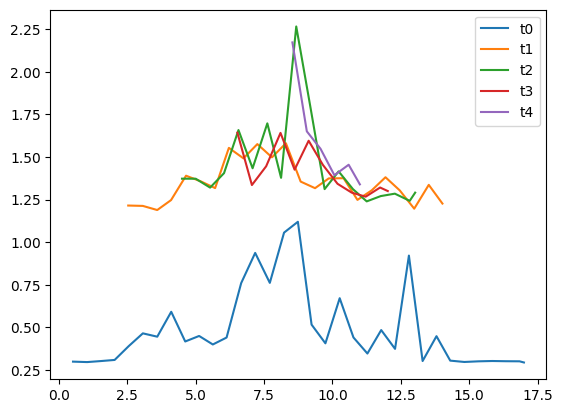

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1
for i, result in enumerate(results):
    x = [(x - START)/UNIT for x in result.keys()]
    y = result.values()
    plt.plot(x, y, label="t%d"%(i,))

plt.legend()
plt.show()